# Predicting torque of / DOF manipulator

<div style="text-align: right;font-size: 0.8em">Document Version 1.0.2, released 04/12/2021</div>

In [4]:

import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
import itertools
from scipy.io import loadmat
from sklearn.cluster import kmeans_plusplus, KMeans

np.random.seed(1234)

### Setup
Loading the data into the following numpy arrays. For the output, only  the first torque variable was used.
Randomly splitting the data from the file ```sarcos_inv.mat``` into a training set (80%) and a validation set (20%).

In [5]:
# Input and output training data
sarcos_mat = loadmat('sarcos_inv.mat')
sarcos = sarcos_mat['sarcos_inv']

#shuffling dataset before splitting
np.random.shuffle(sarcos)
n = sarcos.shape[0] #number of rows
xs_train = sarcos[:int(0.8*n),0:21]
ys_train = sarcos[:int(0.8*n),21:22]

# Input and output validation data
xs_valid = sarcos[int(0.8*n):,0:21]
ys_valid = sarcos[int(0.8*n):,21:22]

# Input and output test data
sarcos_test_mat = loadmat('sarcos_inv_test.mat')
sarcos_test = sarcos_test_mat['sarcos_inv_test']
xs_test = sarcos_test[:,0:21]
ys_test = sarcos_test[:,21:22]

In [6]:

print(xs_train.shape)
print(ys_train.shape)
print(xs_valid.shape)
print(ys_valid.shape)
print(xs_test.shape)
print(ys_test.shape)

(35587, 21)
(35587, 1)
(8897, 21)
(8897, 1)
(4449, 21)
(4449, 1)


Standardizing the data such that
1. Training inputs have mean 0
2. Each training input variable has variance 1
3. The training outputs have mean 0
4. Applying the same transformation to the validation and test data

This was implemented manually for learning purpose

In [7]:
# Store the standardized data in the following variables
xs_train_std = (xs_train - np.mean(xs_train, axis=0)) / np.std(xs_train, axis=0)
ys_train_std = (ys_train - np.mean(ys_train, axis=0)) / np.std(ys_train, axis=0)

xs_valid_std = (xs_valid - np.mean(xs_valid, axis=0)) / np.std(xs_valid, axis=0)
ys_valid_std = (ys_valid - np.mean(ys_valid, axis=0)) / np.std(ys_valid, axis=0)

xs_test_std = (xs_test - np.mean(xs_test, axis=0)) / np.std(xs_test, axis=0)
ys_test_std = (ys_test - np.mean(ys_test, axis=0)) / np.std(ys_test, axis=0)

In [8]:

print(np.mean(xs_train_std))
print(np.mean(ys_train_std))
print(np.mean(xs_valid_std))
print(np.mean(ys_valid_std))
print(np.mean(xs_test_std))
print(np.mean(ys_test_std))

print(np.var(xs_train_std, axis=0))
print(np.var(xs_valid_std, axis=0))
print(np.var(xs_test_std, axis=0))

1.7988736604700613e-17
5.450815378157961e-17
2.1639119481018053e-17
-9.583581914264586e-17
-2.7264507890483246e-17
-2.5553346307398523e-17
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### Implementing a function estimating the variance

In [9]:

def my_variance(xs):
    """Calculate the empirical variance of a given vector of scalars
    
    Arguments
    xs      1d numpy array
    
    Returns
    The empirical variance of the provided vector
    """
    N = xs.shape[0]
    var = 0
    for i in xs:
        var = var + (i - np.mean(xs))**2/(N-1)
    return var

In [10]:
#Calculateing the variance of ys_train_std using the function my_variance
var_ys_train = my_variance(ys_train_std)
print(var_ys_train)

[1.0000281]


In [11]:

#Implementing a function calculating the SMSE between two 1d numpy arrays given a normalizing factor
def my_smse(z1, z2, s):
    """Calculate the Standardized Mean Squared Error (SMSE)
    
    Arguments
    z1      1d numpy array (usually the predictions)
    z2      1d numpy array 
    s       Normalization factor 
    
    Returns
    The SMSE of the provided data
    """
    N =len(z1)
    SMSE = 0
    for i in range(0,N):
        SMSE = SMSE + (z1[i]-z2[i])**2
    SMSE = SMSE/(N*s)
    return(SMSE)

## Linear regression
### Simple linear regression

In [12]:
# This variable contains the weights corresponding to simple linear regression (LS criterion, no bias term)
Phi = xs_train_std
w_lr = la.solve(Phi.T @ Phi, Phi.T @ ys_train_std)
# This variable contains the predictions using w_lr on the validation data
ys_pred_valid = xs_valid_std @ w_lr
# This  contains the resulting smse
smse_lr = my_smse(ys_pred_valid, ys_valid_std, var_ys_train)
print(smse_lr)

[0.07107779]


### Linear regression with polynomial features


In [13]:
def my_poly_features(X, degree):
    
    N = X.shape[0]
    D = X.shape[1]
    poly = np.ones((N,1))
    d_array = list(range(D))
    indices = []
    
    for i in range(1,degree+1):
        comb = list(itertools.combinations_with_replacement(d_array, i))
        indices.append(comb)
    indices =  [item for sublist in indices for item in sublist]
    for i in indices:
        poly_j = np.ones((N,1))
        for j in i:
            xs_current = X[:,j].reshape(N,1)
            poly_j = xs_current*poly_j
        poly = np.hstack((poly,poly_j))
    return poly
#my_poly_features(np.array([[1,2,3],[4,5,6]]), 2)

In [14]:

# This variable contains the weights corresponding to linear regression using polynomial features up to degree 2 and 3
Phi2 = my_poly_features(xs_train_std,2)
w_poly2 = la.solve(Phi2.T @ Phi2, Phi2.T @ ys_train_std)
ys_pred_poly2_valid = my_poly_features(xs_valid_std,2) @ w_poly2
smse_poly2 = my_smse(ys_pred_poly2_valid, ys_valid_std, var_ys_train)
print("smse_poly2 : ",smse_poly2)

# This variable  contains the predictions using w_poly2 and w_poly3 on the validation data
Phi3 = my_poly_features(xs_train_std,3)
w_poly3 = la.solve(Phi3.T @ Phi3, Phi3.T @ ys_train_std)
ys_pred_poly3_valid = my_poly_features(xs_valid_std,3) @ w_poly3
smse_poly3 = my_smse(ys_pred_poly3_valid, ys_valid_std, var_ys_train)
print("smse_poly3 : ",smse_poly3)



smse_poly2 :  [0.03276695]
smse_poly3 :  [0.01600717]


## Clustering
Implementing the basic $K$-Means algorithm.

In [18]:
def my_kmeans(xs, init_centers, n_iter):
    """Runs the K-Means algorithm from a given initialization
    
    Arguments
    xs            2d numpy array of shape (N,D) containing N samples of dimension D
    init_centers  2d numpy array of shape (K,D) containing the initial cluster centers
    n_iter        Number of iterations of the K-Means algorithm
    
    Returns
    An (K,D) numpy array containing the final cluster centers
    """
    def distance(a,b):     
        return np.sqrt(np.sum((a - b)**2))
    
    N = xs.shape[0]
    K = init_centers.shape[0]
    D = init_centers.shape[1]
    distance_arr = np.zeros(K)
    
    #r = 1 if data point X is supposed to belong to cluster k and 0 otherwise.
    r = np.zeros((N,K))
    
    for i in range(0,N):
        for j in range(0,K):
            distance_arr[j] = distance(xs[i],init_centers[j])
        #this xs belongs to cluster with index "k"
        k = np.where(distance_arr==min(distance_arr))[0][0]
        r[i,k] = 1
    #calculate new centroids
    for k in range(0,K):
        cluster_points = np.multiply(xs,r[:,k:k+1])
        cluster_points = cluster_points[~np.all(cluster_points == 0, axis=1)] #remove zero rows
        init_centers[k] = np.mean(cluster_points, axis= 0)
    if n_iter-1 != 0:
        my_kmeans(xs, init_centers, n_iter-1)
    return init_centers
    

Generate test data set and plot it.

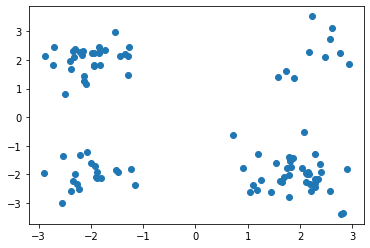

In [19]:
"""
Generate a test data set of 100 points: For each point, independently choose from
four 2d normal distributions having means (−2, 2), (−2,−2), (2,−2), (2, 2) and covariance matrices
0.2I, 0.2I, 0.5I, 0.5I, respectively, with probabilities 0.3, 0.2, 0.4, 0.1. Plot the data set as a scatter
plot.
"""
means = [(-2, 2), (-2,-2), (2,-2), (2, 2)]
I = np.identity(2)
cov = [0.2*I, 0.2*I, 0.5*I, 0.5*I]
#number of points to be drawn from each distribution = probability *(total number of data points)
n = [30 , 20, 40, 10]
# Test data of shape (100,2)
xs_cluster_test = np.random.multivariate_normal(means[0],cov[0],n[0])
for i in range(1,4):
    xs_cluster_test = np.append(xs_cluster_test, np.random.multivariate_normal(means[i],cov[i],n[i]), axis=0)
np.random.shuffle(xs_cluster_test)
plt.scatter(xs_cluster_test[:,0],xs_cluster_test[:,1])
#print(xs_cluster_test.shape)

 Running the $K$-Means algorithm on the test data for $K=2,3,4,5$ clusters and plot the final cluster centers.

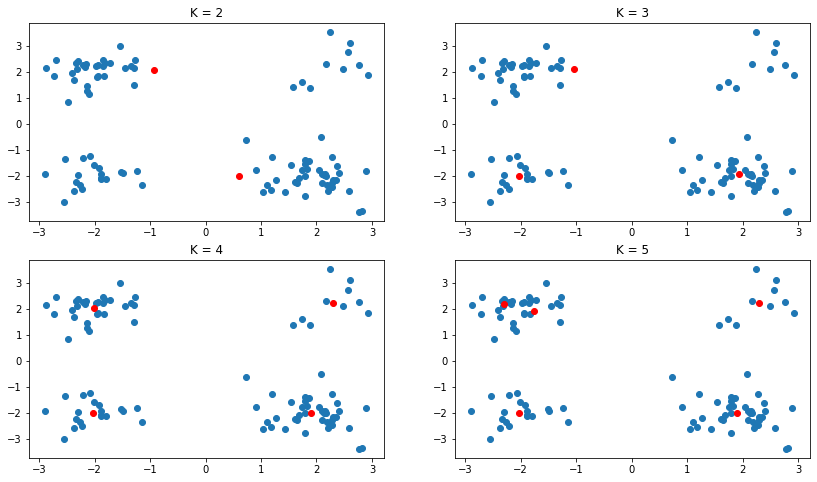

In [20]:
# Using kmeans_plusplus(xs_cluster_test, K, random_state=0) for initialization


figure, axis = plt.subplots(2, 2)
figure.set_size_inches(14, 8)
#for K = 2
K = 2
init_centers, indices = kmeans_plusplus(xs_cluster_test, K, random_state=0)
centers = my_kmeans(xs_cluster_test, init_centers, 5)
axis[0, 0].scatter(xs_cluster_test[:,0],xs_cluster_test[:,1])
axis[0, 0].scatter(centers[:,0],centers[:,1],color="r")
axis[0, 0].set_title("K = 2") 
#for K = 3
K = 3
init_centers, indices = kmeans_plusplus(xs_cluster_test, K, random_state=0)
centers = my_kmeans(xs_cluster_test, init_centers, 5)
axis[0, 1].scatter(xs_cluster_test[:,0],xs_cluster_test[:,1])
axis[0, 1].scatter(centers[:,0],centers[:,1],color="r")
axis[0, 1].set_title("K = 3")
 
#for K = 4
K = 4
init_centers, indices = kmeans_plusplus(xs_cluster_test, K, random_state=0)
centers = my_kmeans(xs_cluster_test, init_centers, 5)
axis[1, 0].scatter(xs_cluster_test[:,0],xs_cluster_test[:,1])
axis[1, 0].scatter(centers[:,0],centers[:,1],color="r")
axis[1, 0].set_title("K = 4")  
#for K = 5
K = 5
init_centers, indices = kmeans_plusplus(xs_cluster_test, K, random_state=0)
centers = my_kmeans(xs_cluster_test, init_centers, 5)
axis[1, 1].scatter(xs_cluster_test[:,0],xs_cluster_test[:,1])
axis[1, 1].scatter(centers[:,0],centers[:,1],color="r")
axis[1, 1].set_title("K = 5")  
# Combine all the operations and display
plt.show()


## Radial Basis Function Network
Find $K=100$ cluster centers using $K$-Means.

In [21]:
# This 100x21 numpy array contains the cluster centers
#init_centers, indices = kmeans_plusplus(xs_train_std, 100, random_state=0)
kmeans = KMeans(n_clusters=100).fit(xs_train_std) #by default uses kmeans++
xs_centers = kmeans.cluster_centers_

 Implementing the Gaussian basis functions and transforming the data accordingly

In [22]:
def gauss_basis_function(x, means, variances):
    return np.exp(-np.sum(((x[:, np.newaxis]-means)**2), axis=-1) / (2*variances))/np.sqrt(2*np.pi*variances)
xs_train_gauss = gauss_basis_function(xs_train_std, xs_centers, 25*25)

Running simple linear regression on the transformed data and evaluate it on the test set

In [23]:
# This contains the resulting predictions on the validation data set
Phi_G= np.hstack((np.ones(xs_train_gauss.shape[0]).reshape(xs_train_gauss.shape[0],1),xs_train_gauss)) #adding additional ones for bias term
w_gauss = la.solve(Phi_G.T @ Phi_G, Phi_G.T @ ys_train_std)
# This variable contains the predictions using w_gauss on the validation data
ys_pred_gauss_valid = gauss_basis_function(xs_valid_std, xs_centers, 25*25)@ w_gauss[1:] + w_gauss[0] # w_gauss[0] is the bias term
# This contains the resulting smse
smse_gauss = my_smse(ys_pred_gauss_valid, ys_valid_std, var_ys_train)
print("smse_gauss :",smse_gauss) 

smse_gauss : [0.04260719]


improving the performance of the RBF network?

### improving the performance of the RBF network?

Manual(without using any libraries) Hyper-parameter tuning : Varying number of cluster centers and standard deviation

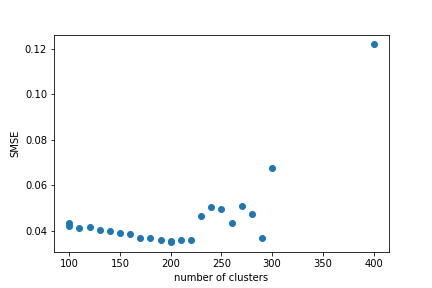

'\n#varying standard deviation \nn=200\nsmse_arr3=[]\nfor std in range(22,27,1):\n    kmeans = KMeans(n_clusters=n).fit(xs_train_std)\n    xs_centers = kmeans.cluster_centers_\n    xs_train_gauss = gauss_basis_function(xs_train_std, xs_centers, std*std)\n    Phi= np.hstack((np.ones(xs_train_gauss.shape[0]).reshape(xs_train_gauss.shape[0],1),xs_train_gauss))\n    w_gauss = la.solve(Phi.T @ Phi, Phi.T @ ys_train_std)\n    ys_pred_gauss_valid = gauss_basis_function(xs_valid_std, xs_centers, 25*25)@ w_gauss[1:] + w_gauss[0]\n    smse_gauss = my_smse(ys_pred_gauss_valid, ys_valid_std, var_ys_train)\n    smse_arr3= np.append(smse_arr3,smse_gauss)\n    print(n , std , smse_gauss)\n'

In [18]:
#below code takes a good amount of time to run hence commented out , the resulting graph was saved and displayed
#findins smse for 100 to 1000 Gaussians Basis functions with steps of 100
"""
smse_arr=[]
for n in range(100,1000,100):
    kmeans = KMeans(n_clusters=n).fit(xs_train_std)
    xs_centers = kmeans.cluster_centers_
    xs_train_gauss = gauss_basis_function(xs_train_std, xs_centers, 25*25)
    Phi= np.hstack((np.ones(xs_train_gauss.shape[0]).reshape(xs_train_gauss.shape[0],1),xs_train_gauss))
    w_gauss = la.solve(Phi.T @ Phi, Phi.T @ ys_train_std)
    ys_pred_gauss_valid = gauss_basis_function(xs_valid_std, xs_centers, 25*25)@ w_gauss[1:] + w_gauss[0]
    smse_gauss = my_smse(ys_pred_gauss_valid, ys_valid_std, var_ys_train)
    smse_arr= np.append(smse_arr,smse_gauss)
    print(smse_gauss) 
"""
#findins smse for 100 to 300 Gaussians Basis functions with steps of 10
"""
smse_arr2=[]
for n in range(100,300,10):
    kmeans = KMeans(n_clusters=n).fit(xs_train_std)
    xs_centers = kmeans.cluster_centers_
    xs_train_gauss = gauss_basis_function(xs_train_std, xs_centers, 25*25)
    Phi= np.hstack((np.ones(xs_train_gauss.shape[0]).reshape(xs_train_gauss.shape[0],1),xs_train_gauss))
    w_gauss = la.solve(Phi.T @ Phi, Phi.T @ ys_train_std)
    ys_pred_gauss_valid = gauss_basis_function(xs_valid_std, xs_centers, 25*25)@ w_gauss[1:] + w_gauss[0]
    smse_gauss = my_smse(ys_pred_gauss_valid, ys_valid_std, var_ys_train)
    smse_arr2= np.append(smse_arr2,smse_gauss)
    print(smse_gauss) 
"""
"""
n = np.arange(100, 1000,100).reshape((9,1))[0:4]
n2 = np.arange(100,300,10).reshape((20,1))
n = np.append(n,n2,axis =0)
#smse_arr = smse_arr.reshape((9,1))
#smse_arr2 = smse_arr2.reshape((20,1))
smse_arr = np.append(smse_arr[0:4],smse_arr2,axis =0)
P = np.append(n,smse_arr,axis =1)
plt.scatter(P[:,0],P[:,1])
plt.xlabel("number of clusters")
plt.ylabel("SMSE")
plt.savefig('clusteropt.png')
"""
from IPython.display import Image
display(Image(filename='clusteropt.png'))
"""
#varying standard deviation 
n=200
smse_arr3=[]
for std in range(22,27,1):
    kmeans = KMeans(n_clusters=n).fit(xs_train_std)
    xs_centers = kmeans.cluster_centers_
    xs_train_gauss = gauss_basis_function(xs_train_std, xs_centers, std*std)
    Phi= np.hstack((np.ones(xs_train_gauss.shape[0]).reshape(xs_train_gauss.shape[0],1),xs_train_gauss))
    w_gauss = la.solve(Phi.T @ Phi, Phi.T @ ys_train_std)
    ys_pred_gauss_valid = gauss_basis_function(xs_valid_std, xs_centers, 25*25)@ w_gauss[1:] + w_gauss[0]
    smse_gauss = my_smse(ys_pred_gauss_valid, ys_valid_std, var_ys_train)
    smse_arr3= np.append(smse_arr3,smse_gauss)
    print(n , std , smse_gauss)
"""
#best results were found for n = 200 clusters and standard deviation = 25 

#### Ridge and Lasso Regularization

In [19]:
from sklearn.linear_model import Ridge,Lasso
xs_valid_gauss = gauss_basis_function(xs_valid_std, xs_centers, 25*25)
model_ridge = Ridge(alpha=0.1, fit_intercept=False)
model_ridge.fit(xs_train_gauss, ys_train_std)

ys_pred_valid_gauss = model_ridge.predict(xs_valid_gauss)

smse_gauss_ridge = my_smse(ys_pred_valid_gauss, ys_valid_std, var_ys_train)
print("smse for Ridge : ", smse_gauss_ridge)

model_Lasso = Lasso(alpha=0.1, fit_intercept=False)
model_Lasso.fit(xs_train_gauss, ys_train_std)

ys_pred_valid_gauss = model_Lasso.predict(xs_valid_gauss)

smse_gauss_Lasso = my_smse(ys_pred_valid_gauss, ys_valid_std, var_ys_train)
print("smse for Lasso : ",smse_gauss_Lasso)

# regularizations were carried out for multiple values of ´alpha´ and it is observed that it increases the smse, this could imply that there is no overfitting present in the model
# best results were obtained without any regularization

smse for Ridge :  [0.8476456]
smse for Lasso :  [0.9999719]


#### Training for 200 cluster centers

In [20]:
kmeans = KMeans(n_clusters=200).fit(xs_train_std) #by default uses kmeans++
xs_centers2 = kmeans.cluster_centers_
xs_train_gauss_improved = gauss_basis_function(xs_train_std, xs_centers2, 25*25)
Phi_G2= np.hstack((np.ones(xs_train_gauss_improved.shape[0]).reshape(xs_train_gauss_improved.shape[0],1),xs_train_gauss_improved))
w_gauss_improved = la.solve(Phi_G2.T @ Phi_G2, Phi_G2.T @ ys_train_std)
# This variable contains the predictions using w_gauss on the validation data
ys_pred_gauss_valid = gauss_basis_function(xs_valid_std, xs_centers2, 25*25)@ w_gauss_improved[1:] + w_gauss_improved[0]
# This contains the resulting smse
smse_gauss_improved = my_smse(ys_pred_gauss_valid, ys_valid_std, var_ys_train)
print("smse_gauss_improved :",smse_gauss_improved) 

smse_gauss_improved : [0.03541261]


### Test

 Evaluating the final improved model  on the test data

In [21]:
# This contains the predictions on the test data set
ys_pred_gauss_test = gauss_basis_function(xs_test_std, xs_centers2, 25*25)@ w_gauss_improved[1:] + w_gauss_improved[0]

# This contains the resulting SMSE on the test data
smse_test = my_smse(ys_pred_gauss_test, ys_test_std, var_ys_train)
print("smse_test : ",smse_test)

smse_test :  [0.03528887]
